<a href="https://colab.research.google.com/github/SoufianEchabarri/Classification-supervis-e-/blob/main/Simulation_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

**Exponentiated quadratic covariance**

In this section, we define the exponentiated quadratic covariance woth the parameter l.


In [4]:
def exponentiated_quadratic(xa, xb,l):
    sq_norm = -(1/(2*l**2))* scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')  # L2 distance (Squared Euclidian)
    return np.exp(sq_norm)

In [61]:
## Test
exponentiated_quadratic(np.array([[2],[5]]), np.array([[3],[4]]),1)

array([[0.60653066, 0.13533528],
       [0.13533528, 0.60653066]])

(100, 1)
(100, 1)
(100, 1)
(100, 1)


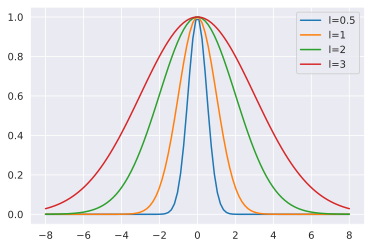

In [5]:
n=100
xlim=(-8,8)
X = np.expand_dims(np.linspace(*xlim, num=n), 1)

l=[1/2,1,2,3]

plt.figure()
for i in l:
  K=exponentiated_quadratic(X,np.array([[0]]),i)
  plt.plot(X,K,label='l={}'.format(i))
  print(X.shape)
plt.legend()  


**Sampling from prior**

We will sample 5 different function realisations from GP with exponentiated quadratic prior without any data. This is with 50-dimensional Gaussian $N(0,k(X,X))$ with $X=[X_1, ...,X_{50}]$.

Text(0.5, 1.0, '5 funtions from the GP prior with EQ kernel (l=1)')

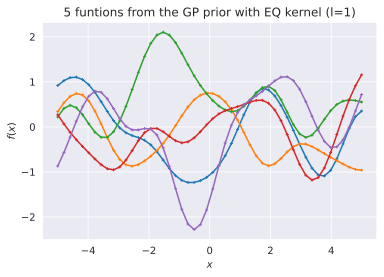

In [6]:
from numpy.core.function_base import linspace
nb_of_samples=50  #numbre of points in each function 
nf=5  #number_of_functions

X=np.expand_dims(linspace(-5,5,nb_of_samples),1)  #Ind variables samples
K=exponentiated_quadratic(X,X,1) #kernel of the data points

#draw the samples from the prior at our data points
ys=np.random.multivariate_normal(mean=np.zeros(nb_of_samples),cov=K,size=nf)

#plot the samples functions

plt.figure(figsize=(6,4))
for i in range(nf):
  plt.plot(X,ys[i],marker='+',markersize=3)
plt.xlabel("$x$",fontsize=10)
plt.ylabel("$f(x)$",fontsize=10)
plt.title("5 funtions from the GP prior with EQ kernel (l=1)")




We change thescale parameter $l$ of the covariance function. 

Text(0.5, 1.0, '5 funtions from the GP prior with EQ kernel (l=5)')

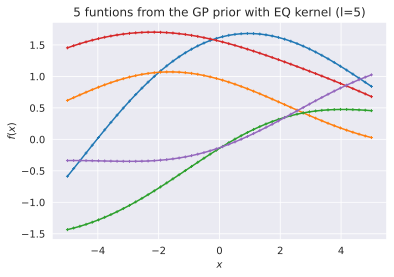

In [7]:
from numpy.core.function_base import linspace
nb_of_samples=50  #numbre of points in each function 
nf=5  #number_of_functions

X=np.expand_dims(linspace(-5,5,nb_of_samples),1)  #Ind variables samples
K=exponentiated_quadratic(X,X,5) #kernel of the data points

#draw the samples from the prior at our data points
ys=np.random.multivariate_normal(mean=np.zeros(nb_of_samples),cov=K,size=nf)

#plot the samples functions

plt.figure(figsize=(6,4))
for i in range(nf):
  plt.plot(X,ys[i],marker='+',markersize=3)
plt.xlabel("$x$",fontsize=10)
plt.ylabel("$f(x)$",fontsize=10)
plt.title("5 funtions from the GP prior with EQ kernel (l=5)")

**Regressor with GP: prediction from posterior**

We will define a function that calculate the posterior mean and covariance matrix for y2 based on the corresponding input X2, the observations (y1,x1) and the kernel prior.

$$
\begin{aligned}
p\left(\mathbf{y}_{2} \mid \mathbf{y}_{1}, X_{1}, X_{2}\right) &=\mathcal{N}\left(\mu_{2 \mid 1}, \Sigma_{2 \mid 1}\right) \\
\mu_{2 \mid 1} &=\mu_{2}+\Sigma_{21} \Sigma_{11}^{-1}\left(\mathbf{y}_{1}-\mu_{1}\right) \\
&=\Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_{1} \quad(\text { if assume mean prior } \mu=0) \\
\Sigma_{2 \mid 1} &=\Sigma_{22}-\Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}
\end{aligned}
$$
We can write these as follows (Note here that $\Sigma_{11}=\Sigma_{11}^{\top}$ since it's symmetric.):
$$
\begin{aligned}
\mu_{2 \mid 1} &=\Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_{1} & \Sigma_{2 \mid 1} &=\Sigma_{22}-\Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12} \\
&=\left(\Sigma_{11}^{-1} \Sigma_{12}\right)^{\top} \mathbf{y}_{1} & &=\Sigma_{22}-\left(\Sigma_{11}^{-1} \Sigma_{12}\right)^{\top} \Sigma_{12}
\end{aligned}
$$


In [8]:
def GP(X1,Y1,X2,ker,l):
  K11=ker(X1,X1,l) #kernel of the observations
  K12=ker(X1,X2,l) #kernel of the observations vs to-predict
  solved=scipy.linalg.solve(K11,K12,assume_a='pos').T # solve a*x=b | K11=a, K12=b
  
  #posterior mean
  mu2=solved@Y1
  #posterior covariance
  K22=ker(X2,X2,l)
  K2=K22-(solved@K12)
  return mu2, K2

In [85]:
#Test
X1=np.expand_dims(linspace(-2,2,10),1)
Y1=np.cos(X1)
X2=np.array([[0],[1/2],[3/2]])
GP(X1,Y1,X2,ker=exponentiated_quadratic,l=1)

(array([[0.99994905],
        [0.87763805],
        [0.07084106]]),
 array([[ 1.50921607e-08, -1.61124254e-08, -2.56621554e-08],
        [-1.61124254e-08,  1.76214394e-08,  2.94543113e-08],
        [-2.56621554e-08,  2.94543111e-08,  5.47299382e-08]]))

**The posterior distribution based on 8  observations $(X_1,Y_1)$ from a sine function.**



In [45]:
# Compute the posterior mean and covariance

#Define the true function that we want regress on
f_cos= lambda x: (np.cos(x)).flatten()

n1=8   #number of points to condition on (training points) (X1,Y1)
n2=75  # number of points in posterior (test points) 
nf=5   #Number of functions that we be sampled from the posterior
I=(-6,6)

# Sample observartion (X1,Y1) on the function
X1=np.random.uniform(I[0]+2,I[1]-2,size=(n1,1))
Y1=f_cos(X1)
#Predict points at uniform spacing to capture function
X2=np.linspace(I[0],I[1],n2).reshape(-1,1)
#Compute the posteriro mean and covariance
mu2, K2=GP(X1,Y1,X2,ker=exponentiated_quadratic,l=1)  # mu2: n2x1  K2:n2xn2
#Compute the standard deviation at the test point 
sig2=np.sqrt(np.diag(K2))
#Draw 5 samples of the prior
Yp=np.random.multivariate_normal(mean=np.zeros(X2.shape[0]), 
                    cov=exponentiated_quadratic(X2,X2,1),size=nf)
#Draw 5 samples of the posterior 
Y2=np.random.multivariate_normal(mean=mu2, cov=K2,size=nf)

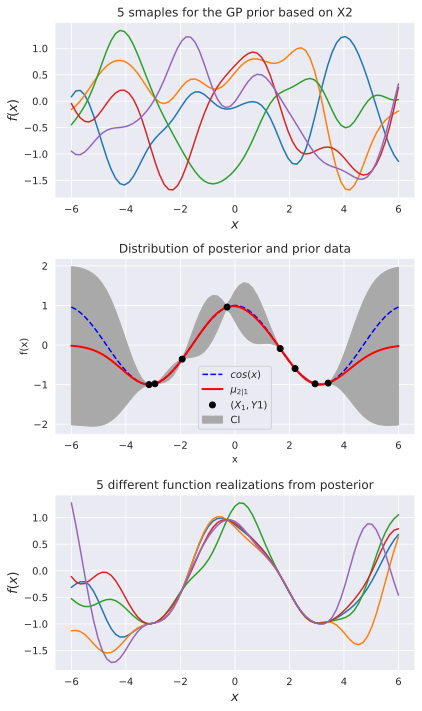

In [46]:
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(6,10))
# Plot 5 samples for the GP prior (X2)
ax1.plot(X2,Yp.T)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$f(x)$', fontsize=13)
ax1.set_title('5 smaples for the GP prior based on X2')

## Plot the posterior distribution and some samples
# plot the distribution of the function (mean, covariance)
ax2.plot(X2,f_cos(X2),'b--',label='$cos(x)$')
ax2.plot(X2,mu2,'r-',lw=2,label='$\mu_{2|1}$')
ax2.plot(X1,Y1,'ko',label='$(X_1,Y1)$')
ax2.fill_between(X2.flat,mu2-2*sig2,mu2+2*sig2,color='darkgray',label='CI')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title('Distribution of posterior and prior data')
ax2.legend();

# plot some samples from this function
ax3.plot(X2,Y2.T,'-')
ax3.set_xlabel('$x$', fontsize=13)
ax3.set_ylabel('$f(x)$', fontsize=13)
ax3.set_title('5 different function realizations from posterior')
plt.tight_layout()
plt.show()



**Noisy observations**

The prediction made above assume that observations $f(X_1)=Y_1$ come from the noiseless distribution. 
Now, we will make the prediction from noisy observations $f(X_1)=Y_1+ϵ$.
The noise can be modelled by adding it to th covariance kernel of oour observations:
$$Σ=k(X1,X1)+σ_{ϵ}^2I$$.



In [48]:
def GP_noisy(X1,Y1,X2,ker,l,sigma):
  K11=ker(X1,X1,l)+((sigma**2)*np.eye(n1)) #kernel of the observations
  K12=ker(X1,X2,l) #kernel of the observations vs to-predict
  solved=scipy.linalg.solve(K11,K12,assume_a='pos').T # solve a*x=b | K11=a, K12=b
  
  #posterior mean
  mu2=solved@Y1
  #posterior covariance
  K22=ker(X2,X2,l)
  K2=K22-(solved@K12)
  return mu2, K2

In [61]:
sigma=1
Y1=Y1+((sigma**2)*np.random.randn(n1))  #noisy observations

#Posterior mean and covariance
mu2,K2=GP_noisy(X1,Y1,X2,ker=exponentiated_quadratic,l=1,sigma=sigma)
#IC
sig2=np.sqrt(np.diag(K2))
#posteriori distribution-predicion
Y2=np.random.multivariate_normal(mean=mu2,cov=K2,size=5)


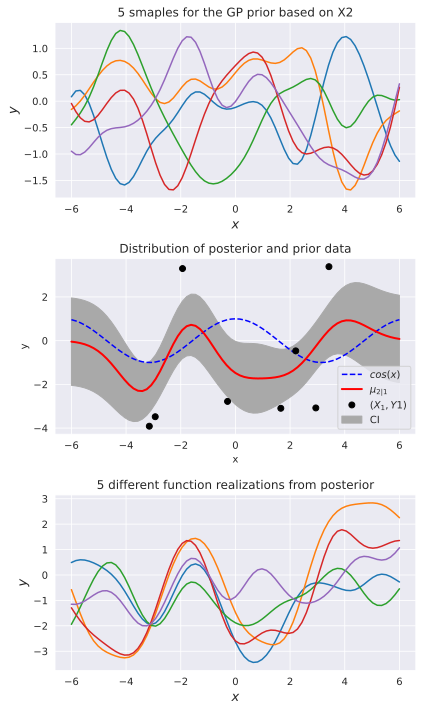

In [62]:
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(6,10))
# Plot 5 samples for the GP prior (X2)
ax1.plot(X2,Yp.T)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('5 smaples for the GP prior based on X2')

## Plot the posterior distribution and some samples
# plot the distribution of the function (mean, covariance)
ax2.plot(X2,f_cos(X2),'b--',label='$cos(x)$')
ax2.plot(X2,mu2,'r-',lw=2,label='$\mu_{2|1}$')
ax2.plot(X1,Y1,'ko',label='$(X_1,Y1)$')
ax2.fill_between(X2.flat,mu2-2*sig2,mu2+2*sig2,color='darkgray',label='CI')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Distribution of posterior and prior data')
ax2.legend();

# plot some samples from this function
ax3.plot(X2,Y2.T,'-')
ax3.set_xlabel('$x$', fontsize=13)
ax3.set_ylabel('$y$', fontsize=13)
ax3.set_title('5 different function realizations from posterior')
plt.tight_layout()
plt.show()